In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
identifier_name = 'flight_id'

features_names = [
 'month_day',
 'month',
 'day',
 'actual_offblock_time_hour_minute',
 'actual_offblock_time_hour',
 'actual_offblock_time_minute',
 'adep',
 'country_code_adep',
 'arrival_time_hour_minute',
 'arrival_time_hour',
 'arrival_time_minute',
 'ades',
 'country_code_ades',
 'aircraft_type',
 'wtc',
 'airline',
 'flight_duration',
 'taxiout_time',
 'flown_distance',
 'latitude_count',
 'latitude_mean',
 'latitude_std',
 'latitude_min',
 'latitude_25percentile',
 'latitude_median',
 'latitude_75percentile',
 'latitude_max',
 'longitude_count',
 'longitude_mean',
 'longitude_std',
 'longitude_min',
 'longitude_25percentile',
 'longitude_median',
 'longitude_75percentile',
 'longitude_max',
 'altitude_count',
 'altitude_mean',
 'altitude_std',
 'altitude_min',
 'altitude_25percentile',
 'altitude_median',
 'altitude_75percentile',
 'altitude_max',
 'groundspeed_count',
 'groundspeed_mean',
 'groundspeed_std',
 'groundspeed_min',
 'groundspeed_25percentile',
 'groundspeed_median',
 'groundspeed_75percentile',
 'groundspeed_max',
 'track_count',
 'track_mean',
 'track_std',
 'track_min',
 'track_25percentile',
 'track_median',
 'track_75percentile',
 'track_max',
 'vertical_rate_count',
 'vertical_rate_mean',
 'vertical_rate_std',
 'vertical_rate_min',
 'vertical_rate_25percentile',
 'vertical_rate_median',
 'vertical_rate_75percentile',
 'vertical_rate_max',
 'u_component_of_wind_count',
 'u_component_of_wind_mean',
 'u_component_of_wind_std',
 'u_component_of_wind_min',
 'u_component_of_wind_25percentile',
 'u_component_of_wind_median',
 'u_component_of_wind_75percentile',
 'u_component_of_wind_max',
 'v_component_of_wind_count',
 'v_component_of_wind_mean',
 'v_component_of_wind_std',
 'v_component_of_wind_min',
 'v_component_of_wind_25percentile',
 'v_component_of_wind_median',
 'v_component_of_wind_75percentile',
 'v_component_of_wind_max',
 'temperature_count',
 'temperature_mean',
 'temperature_std',
 'temperature_min',
 'temperature_25percentile',
 'temperature_median',
 'temperature_75percentile',
 'temperature_max',
 'specific_humidity_count',
 'specific_humidity_mean',
 'specific_humidity_std',
 'specific_humidity_min',
 'specific_humidity_25percentile',
 'specific_humidity_median',
 'specific_humidity_75percentile',
 'specific_humidity_max'
]

target_name = 'tow'

global_random_state = 123

In [3]:
encoded_challenge_set = pd.read_csv('data/encoded_challenge_set.csv')
encoded_challenge_set = encoded_challenge_set.fillna(0)
features = encoded_challenge_set[features_names]
target = encoded_challenge_set[target_name]

In [4]:
# Function to score model using Root Mean Square Error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# Create a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=global_random_state)

In [5]:
param_grid = {
    'n_estimators': list(range(1,102,15)),
    'max_depth': list(range(1, 11, 3)),
    'learning_rate': [x / 10 for x in list(range(1, 10, 3))],
    'subsample': [x / 10 for x in list(range(1, 11, 3))],
    'colsample_bytree': [x / 10 for x in list(range(1, 11, 3))]
}

model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=global_random_state
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', # Use RMSE (negative because scikit-learn maximizes scores)
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(features, target)

best_params = grid_search.best_params_
print("Best parameters:", best_params)
print("Best RMSE:", -grid_search.best_score_) # Negate the score to get RMSE

Fitting 3 folds for each of 1344 candidates, totalling 4032 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 91, 'subsample': 1.0}
Best RMSE: 3061.226005567363


<Figure size 1000x800 with 0 Axes>

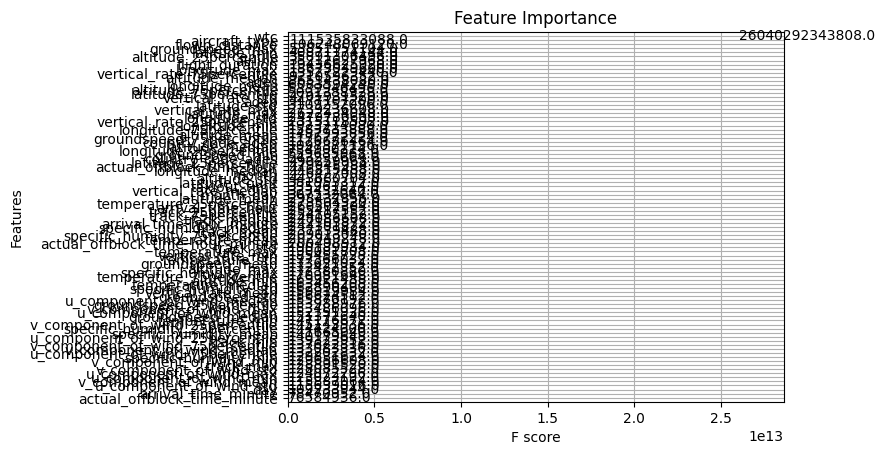

In [6]:
best_model = grid_search.best_estimator_

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, importance_type='gain')
plt.title('Feature Importance')
plt.show()

In [7]:
booster = best_model.get_booster()

# Create a DataFrame with all feature names
all_features = pd.DataFrame(features.columns, columns=['Feature'])

# Get the importance of the features
importance_dict = booster.get_score(importance_type='gain')
importance_df = pd.DataFrame(importance_dict.items(), columns=['Feature', 'Importance'])

# Merge with all features to include those with zero importance
importance_full_df = all_features.merge(importance_df, on='Feature', how='left').fillna(0)

# Sort the DataFrame in ascending order
importance_full_df_sorted = importance_full_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

display(importance_full_df_sorted)

,Feature,Importance
0,wtc,2.604029e+13
1,aircraft_type,1.115358e+11
2,flown_distance,1.062481e+11
3,groundspeed_max,5.385195e+10
4,latitude_min,4.087117e+10
5,altitude_25percentile,3.589131e+10
6,airline,3.521263e+10
7,flight_duration,1.943663e+10
8,longitude_max,1.867305e+10
9,vertical_rate_75percentile,1.352723e+10


In [8]:
print(list(importance_full_df_sorted["Importance"].values))

[26040292343808.0, 111535833088.0, 106248069120.0, 53851951104.0, 40871174144.0, 35891306496.0, 35212627968.0, 19436625920.0, 18673049600.0, 13527229440.0, 9210596352.0, 8651438080.0, 6083594240.0, 5339946496.0, 5091388928.0, 4701931520.0, 4477107200.0, 3109252096.0, 2739236608.0, 2622434048.0, 2479780608.0, 2315118592.0, 1923214080.0, 1583733888.0, 1487993856.0, 1176772224.0, 1126686464.0, 1097371136.0, 734900224.0, 559635968.0, 543297664.0, 490259968.0, 479945984.0, 446815488.0, 446427008.0, 443680704.0, 381953312.0, 335961824.0, 323432640.0, 307332064.0, 298437856.0, 273504320.0, 260502304.0, 255417552.0, 254105152.0, 248086608.0, 247103872.0, 244301824.0, 237139488.0, 209013040.0, 202949248.0, 200498912.0, 190189984.0, 190081808.0, 185455728.0, 177366032.0, 173621024.0, 172422352.0, 172380880.0, 170981648.0, 169921488.0, 163456208.0, 162890400.0, 159919984.0, 156624512.0, 155870192.0, 153988976.0, 153486096.0, 152151936.0, 151372640.0, 147176672.0, 145143936.0, 144424000.0, 1416650

In [9]:
print(list(importance_full_df_sorted["Feature"].values))

['wtc', 'aircraft_type', 'flown_distance', 'groundspeed_max', 'latitude_min', 'altitude_25percentile', 'airline', 'flight_duration', 'longitude_max', 'vertical_rate_75percentile', 'altitude_median', 'ades', 'longitude_mean', 'altitude_75percentile', 'latitude_75percentile', 'vertical_rate_std', 'adep', 'latitude_std', 'vertical_rate_max', 'latitude_max', 'longitude_std', 'vertical_rate_25percentile', 'longitude_min', 'longitude_75percentile', 'altitude_mean', 'groundspeed_75percentile', 'country_code_adep', 'latitude_median', 'longitude_25percentile', 'groundspeed_min', 'country_code_ades', 'latitude_25percentile', 'actual_offblock_time_hour', 'longitude_median', 'month', 'altitude_std', 'latitude_count', 'taxiout_time', 'vertical_rate_median', 'month_day', 'latitude_mean', 'temperature_25percentile', 'arrival_time_hour', 'track_25percentile', 'track_75percentile', 'track_median', 'arrival_time_hour_minute', 'specific_humidity_median', 'track_mean', 'specific_humidity_75percentile', 't